# Variational Autoencoder Galaxy generator

## Import libraries

In [1]:
import os
from glob import glob
from utils.custom_utils import RetrieveData, show_images
import random as rd

from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

## Download data

In [2]:
DataURL='https://tinyurl.com/mr2yc5nx'

RetrieveData(DataURL)

## dataloader and data verification

In [3]:
image_path='./data/images_gz2/images'

In [4]:
class GalaxyZoo2(Dataset):
    def __init__(self, img_dir, transform=None, train=None):
        self.transform = transform
        self.img_dir = img_dir
        
        images = glob(os.path.join(img_dir,'*.jpg'))
        rd.shuffle(images)
        
        cut = int(0.6*len(images))
        if train==True:
            self.images = images[:cut]
        elif train==False:
            self.images = images[cut:]
        else:
            self.images = images
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, index):
        img_path = self.images[index]
        with Image.open(img_path) as im:
            if self.transform:
                im = self.transform(im)
            return im.float()/255

In [5]:
trainset=GalaxyZoo2(image_path, transform=transforms.PILToTensor())

In [6]:
trainloader=DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

torch.Size([4, 3, 424, 424])


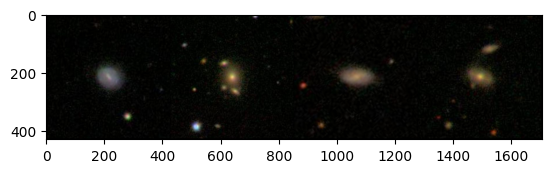

In [7]:
images=next(iter(trainloader))
print(images.shape)
show_images(utils.make_grid(images))

## MLP VAE

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'this instance use {device}')

torch.manual_seed(100)


image_size = 424
channels = 3
batch_size = 32

#hyperparameters of the NN specifically
input_features = channels*image_size*image_size # RGB pixel (dim=3)* 424*424 image
output_features = 128 # size of output of encoder = input of decoder
hidden_features = 200 # arbitrary
latent_space_size = 20 #size of the latent space --> arbitrary
learning_rate = 3e-4 # arbitrary
num_epochs = 10 # arbitrary

model_name = "MLP_VAE"

this instance use cuda


In [9]:
class MLP_VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128, latent_dim=2):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, output_dim),
                                    )
        
        self.mu = nn.Linear(output_dim, latent_dim)
        self.logvar = nn.Linear(output_dim, latent_dim)
        
        self.latent_mapping = nn.Linear(latent_dim, output_dim)
        
        self.decoder = nn.Sequential(nn.Linear(output_dim, hidden_dim),
                                     nn.ReLU(),
                                     nn.Linear(hidden_dim, input_dim),
                                    )
    
    def encode(self, x):
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        latent_z = self.latent_mapping(z)
        out = self.decoder(latent_z)
        return torch.sigmoid(out)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar

In [10]:
def ElboLoss(x, x_reconstructed, mu, logvar):
    criterion = F.binary_cross_entropy(x_reconstructed, x)
    KL_div = 0.5*torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
    elbo = torch.mean(criterion - KL_div)
    return elbo

In [11]:
trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [12]:
model = MLP_VAE(input_dim=input_features).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [13]:
def train_MLP(num_epochs):
    """
    Train the model (VAE) onto the data in the trainloader
    """
    train_avg_loss = []
    loop = tqdm(enumerate(trainloader))
    
    for i in range(num_epochs):
        train_losses = []
        loop
        
        for i,x in loop:
            x = x.to(device).view(x.shape[0],-1)
            x_reconstructed, mu, logvar = model(x)
        
            loss = ElboLoss(x, x_reconstructed, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
            train_losses.append(loss.detach())
                    
        train_avg_loss.append(torch.mean(torch.FloatTensor(train_losses)))

    return train_avg_loss #we could also return the reconstruction loss and the regularization loss individually, but in the end it is the ELBO loss that is important

In [14]:
train_avg_loss = train_MLP(1)

4565it [09:42,  7.83it/s, loss=0.168] 


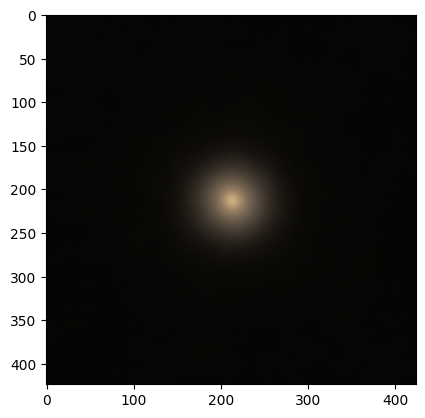

In [15]:
model=model.to('cpu')
images=next(iter(trainloader))
test,mu,logvar=model(images.view(images.shape[0],-1))
show_images(utils.make_grid(test.view(test.shape[0],3,424,424)[0]))

## Conv VAE

In [74]:
torch.cuda.empty_cache()

In [75]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(f'this instance use {device}')

torch.manual_seed(100)


image_size = 424
channels = 3
batch_size = 32

#hyperparameters of the NN specifically
input_features = channels*image_size*image_size # RGB pixel (dim=3)* 424*424 image
output_features = 128 # size of output of encoder = input of decoder
hidden_features = 200 # arbitrary
latent_space_size = 20 #size of the latent space --> arbitrary
learning_rate = 3e-4 # arbitrary
num_epochs = 10 # arbitrary

model_name = "MLP_VAE"

this instance use cuda


In [76]:
class Conv_VAE(nn.Module):
    def __init__(self,channels=3, featureDim=12*416*416,latent_dim=5):
        super().__init__()
        
        self.encoder = nn.Sequential(nn.Conv2d(channels, 6, 5),
                                     nn.ReLU(),
                                     nn.Conv2d(6, 12, 5),
                                     nn.ReLU(),
                                     nn.Flatten(),
                                    )
        
        self.mu = nn.Linear(featureDim, latent_dim)
        self.logvar = nn.Linear(featureDim, latent_dim)
        
        self.latent_mapping = nn.Linear(latent_dim, featureDim)
        
        self.decoder = nn.Sequential(nn.Unflatten(-1,(12,416,416)),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(12, 6, 5),
                                     nn.ReLU(),
                                     nn.ConvTranspose2d(6, channels, 5),
                                    )
    
    def encode(self, x):
        encoder = self.encoder(x)
        mu, logvar = self.mu(encoder), self.logvar(encoder)
        return mu, logvar
    
    def sample_z(self, mu, logvar):
        eps = torch.rand_like(mu)
        return mu + eps * torch.exp(0.5 * logvar)
    
    def decode(self, z):
        latent_z = self.latent_mapping(z)
        out = self.decoder(latent_z)
        return torch.sigmoid(out)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.sample_z(mu, logvar)
        output = self.decode(z)
        return output, mu, logvar

In [77]:
def ElboLoss(x, x_reconstructed, mu, logvar):
    criterion = F.binary_cross_entropy(x_reconstructed, x)
    KL_div = 0.5*torch.sum(1 + logvar - mu**2 - torch.exp(logvar))
    elbo = torch.mean(criterion - KL_div)
    return elbo

In [78]:
trainset = GalaxyZoo2(image_path, transform=transforms.Compose([transforms.PILToTensor(),]), train=True)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

In [79]:
model = Conv_VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [80]:
def train_Conv(num_epochs):
    """
    Train the model (VAE) onto the data in the trainloader
    """
    train_avg_loss = []
    loop = tqdm(enumerate(trainloader))
    
    for i in range(num_epochs):
        train_losses = []
        loop
        
        for i,x in loop:
            x = x.to(device)
            x_reconstructed, mu, logvar = model(x)
        
            loss = ElboLoss(x, x_reconstructed, mu, logvar)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            loop.set_postfix(loss=loss.item())
            train_losses.append(loss.detach())
                    
        train_avg_loss.append(torch.mean(torch.FloatTensor(train_losses)))

    return train_avg_loss #we could also return the reconstruction loss and the regularization loss individually, but in the end it is the ELBO loss that is important

In [81]:
train_avg_loss = train_Conv(1)

806it [03:27,  3.88it/s, loss=92.8]   


KeyboardInterrupt: 

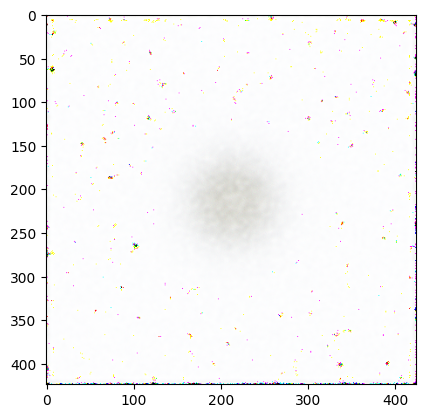

In [84]:
model=model.to('cpu')
images=next(iter(trainloader))
test,mu,logvar=model(images)
sub=test[0]-test[1]
show_images(utils.make_grid(sub))